# Rural vs. Urban Presidential Vote Weight

The 2016 election results have, yet again, raised interest in the question of whether the electoral college (EC) is necessary. Here, I'll compute the relative weight each rural voter gets versus the weight of an urban voter. My hypothesis is that there exists a detectable difference in the relative weights that favors the rural voter. The unit I'll use to measure this I will call "voting power" and is defined as the fraction of EC votes per voter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import re
import operator
import openpyxl

def round_to (num, precision):
    correction = 0.5 if num >= 0 else -0.5
    return int(num/precision + correction)*precision
def fractional_difference (val, base):
    return (val - base)/base

## Gathering the Data

In [2]:
#census_df = pd.read_csv("http://www2.census.gov/geo/docs/reference/ua/PctUrbanRural_County.txt")
census_df = pd.read_csv("http://www2.census.gov/geo/docs/reference/ua/PctUrbanRural_State.txt",
                       index_col='STATENAME')
census_df.fillna(0, inplace=True)
pd.set_option('display.max_columns', None)
census_df

,STATE,POP_ST,AREA_ST,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POPDEN_URBAN,POP_UA,POPPCT_UA,AREA_UA,AREAPCT_UA,POPDEN_UA,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
STATENAME,,,,,,,,,,,,,,,,,,,,,,,
Alabama,1,4779736,131170787086,2821804,59.04,5716365701,4.36,1278.5,2325304,48.65,4415733067,3.37,1363.9,496500,10.39,1300632634,0.99,988.7,1957932,40.96,125454421385,95.64,40.4
Alaska,2,710231,1477953211577,468893,66.02,673703920,0.05,1802.6,315756,44.46,362866427,0.02,2253.7,153137,21.56,310837493,0.02,1276.0,241338,33.98,1477279507657,99.95,0.4
Arizona,4,6392017,294207314414,5740659,89.81,5663221936,1.92,2625.4,5117783,80.07,4696616836,1.60,2822.2,622876,9.74,966605100,0.33,1669.0,651358,10.19,288544092478,98.08,5.8
Arkansas,5,2915918,134771261408,1637589,56.16,2841198188,2.11,1492.8,1152837,39.54,1881196989,1.40,1587.2,484752,16.62,960001199,0.71,1307.8,1278329,43.84,131930063220,97.89,25.1
California,6,37253956,403466310059,35373606,94.95,21287926350,5.28,4303.7,33427689,89.73,18915178185,4.69,4577.1,1945917,5.22,2372748165,0.59,2124.1,1880350,5.05,382178383709,94.72,12.7
Colorado,8,5029196,268431246426,4332761,86.15,3956737225,1.47,2836.1,3865471,76.86,3258048896,1.21,3072.9,467290,9.29,698688329,0.26,1732.2,696435,13.85,264474509201,98.53,6.8
Connecticut,9,3574097,12541641427,3144942,87.99,4730500209,37.72,1721.9,3031980,84.83,4500564038,35.88,1744.8,112962,3.16,229936171,1.83,1272.4,429155,12.01,7811141218,62.28,142.3
Delaware,10,897934,5046703785,747949,83.30,1053792304,20.88,1838.3,616982,68.71,740579379,14.67,2157.7,130967,14.59,313212925,6.21,1083.0,149985,16.70,3992911481,79.12,97.3
District of Columbia,11,601723,158114680,601723,100.00,158114680,100.00,9856.5,601723,100.00,158114680,100.00,9856.5,0,0.00,0,0.00,0.0,0,0.00,0,0.00,0.0


The definitions of the column labels are given at: https://www.census.gov/geo/reference/ua/ualists_layout.html

More information can be found at: https://www.census.gov/geo/reference/ua/urban-rural-2010.html

The columns I'm most interested in are the `POPPCT_URBAN` and `POPPCT_RURAL` columns. These summarize the percentages of the urban and rural populations on a per county level and always add to 100.0. Of course, `POP_ST`, `POP_URBAN`, and `POP_RURAL` are also of interest as these are the total populations of the state, all urban areas, and all rural areas, respectively.

Here are a few plots to visualize the census information.

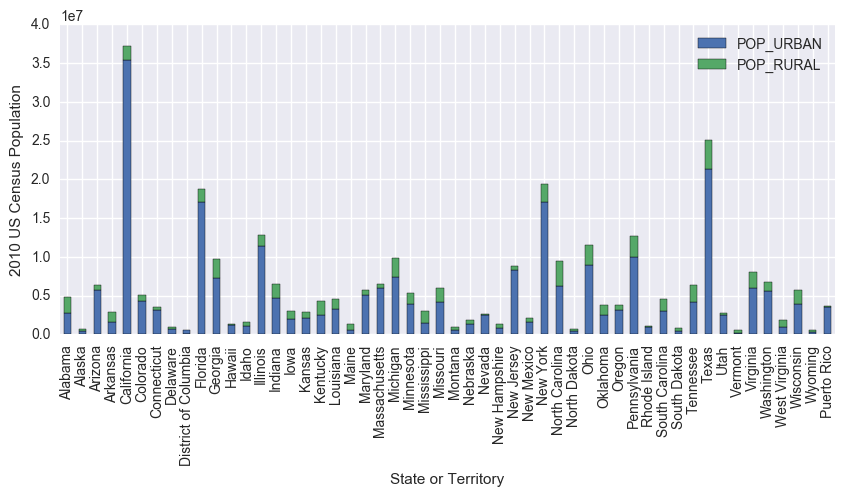

In [3]:
%matplotlib inline
g = census_df[['POP_URBAN', 'POP_RURAL']].plot(
    kind='bar', 
    logy=False, legend=True, 
    grid=True, figsize=(10, 4), stacked=True)
nothing = g.set_xticklabels(g.get_xticklabels(), rotation=90)
nothing = g.set_ylabel('2010 US Census Population')
nothing = g.set_xlabel('State or Territory')

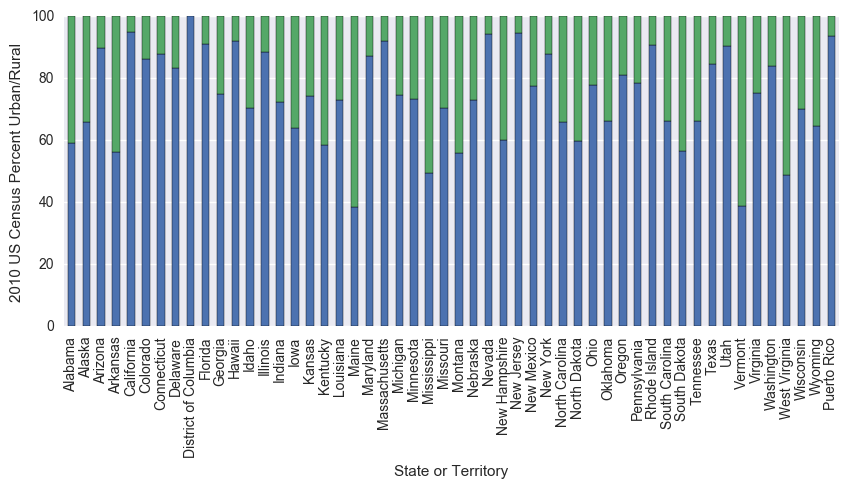

In [4]:
%matplotlib inline
g = census_df[['POPPCT_URBAN', 'POPPCT_RURAL']].plot(
    kind='bar', 
    logy=False, legend=False, 
    grid=True, figsize=(10, 4), stacked=True)
nothing = g.set_xticklabels(g.get_xticklabels(), rotation=90)
nothing = g.set_ylabel('2010 US Census Percent Urban/Rural')
nothing = g.set_xlabel('State or Territory')

Now to manually enter in the EC vote count per state.

In [5]:
electoral_college_votes_2016 = {
    'Alabama': 9,
    'Alaska' : 3,
    'Arizona': 11,
    'Arkansas': 6,
    'California': 55,
    'Colorado': 9,
    'Connecticut': 7,
    'Delaware': 3,
    'District of Columbia': 3,
    'Florida': 29,
    'Georgia': 16,
    'Hawaii': 4,
    'Idaho': 4,
    'Illinois': 20,
    'Indiana': 11,
    'Iowa': 6,
    'Kansas': 6,
    'Kentucky': 8,
    'Louisiana': 8,
    'Maine': 4,
    'Maryland': 10,
    'Massachusetts': 11,
    'Michigan': 16,
    'Minnesota': 10,
    'Mississippi': 6,
    'Missouri': 10,
    'Montana': 3,
    'Nebraska': 5,
    'Nevada': 6,
    'New Hampshire': 4,
    'New Jersey': 14,
    'New Mexico': 5,
    'New York': 29,
    'North Carolina': 15,
    'North Dakota': 3,
    'Ohio': 18,
    'Oklahoma': 7,
    'Oregon': 7,
    'Pennsylvania': 20,
    'Rhode Island': 4,
    'South Carolina': 9,
    'South Dakota': 3,
    'Tennessee': 11,
    'Texas': 38,
    'Utah': 6,
    'Vermont': 3,
    'Virginia': 13,
    'Washington': 12,
    'West Virginia': 5,
    'Wisconsin': 10,
    'Wyoming': 3
}

# sanity check: sum should equal 538
s = 0
for k, v in electoral_college_votes_2016.items():
    s = s+v
s == 538

True

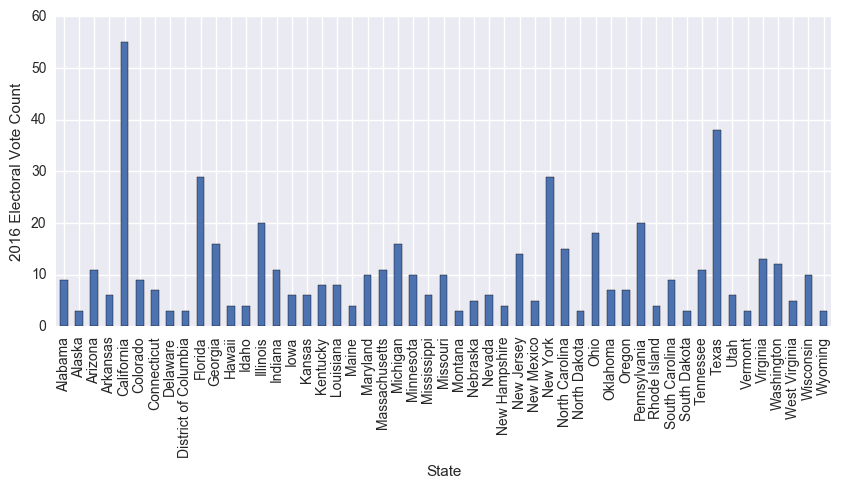

In [6]:
g = pd.DataFrame.from_dict({'VoteCount': electoral_college_votes_2016}).plot(kind='bar', 
    logy=False, legend=False, 
    grid=True, figsize=(10, 4))
nothing = g.set_xticklabels(g.get_xticklabels(), rotation=90)
nothing = g.set_ylabel('2016 Electoral Vote Count')
nothing = g.set_xlabel('State')

## Nationwide Analysis

To start, for each state, the average voting power is easily computed. Just divide the state's EC votes by the state's total electorate (those over 18 years of age). Total voting population is taken from http://www.census.gov/data/tables/time-series/demo/voting-and-registration/electorate-profiles-2016.html (each spreadsheet in copied locally into a folder labeled VotingPop2016). The following assumes that the age demographics for the urban and rural electorate are the same and that voter turnout is proportional to population (these elections tell us otherwise, but without detailed information on rural vs. urban voter turnout this is the best I can do (for instance, http://www.wsj.com/articles/voter-turnout-fell-with-biggest-declines-in-urban-areas-1478741378)).

In [7]:
electorate_by_state_2016 = {}
for k in census_df.index:
    electorate_by_state_2016[k] = float(openpyxl.load_workbook('VotingPop2016/'+k.replace(' ', '')+'.xlsx').active['B3'].value)

electorate_fraction_by_state_2016 = electorate_by_state_2016.copy()
for k in census_df.index:
    electorate_fraction_by_state_2016[k] = electorate_by_state_2016[k]/census_df.POP_ST[k]

In [8]:
EC_votes_per_electorate = electoral_college_votes_2016.copy()
for k, v in EC_votes_per_electorate.items():
    electorate = electorate_by_state_2016[k]
    EC_votes_per_electorate[k] = float(electoral_college_votes_2016[k])/electorate
for k, v in sorted(EC_votes_per_electorate.items(), key=operator.itemgetter(1)):
    print '{:>20}:  {:<20}'.format(k,EC_votes_per_electorate[k])

             Florida:  2.00804923072e-06   
        Pennsylvania:  2.05079364689e-06   
                Ohio:  2.0535862804e-06    
      North Carolina:  2.05582665818e-06   
            New York:  2.11601744211e-06   
            Virginia:  2.14439922511e-06   
            Michigan:  2.15155615333e-06   
               Texas:  2.16846657001e-06   
            Missouri:  2.18925160653e-06   
          California:  2.19975257183e-06   
            Illinois:  2.21787198953e-06   
             Georgia:  2.23212168188e-06   
       Massachusetts:  2.23374791018e-06   
           Tennessee:  2.23596595965e-06   
             Indiana:  2.26486715422e-06   
          New Jersey:  2.27489654908e-06   
           Wisconsin:  2.30384647904e-06   
            Colorado:  2.30947711898e-06   
           Louisiana:  2.31549954877e-06   
             Arizona:  2.33523435563e-06   
            Maryland:  2.35849779728e-06   
          Washington:  2.36136801921e-06   
              Oregon:  2.3678791

I've printed them in sorted order of increasing voting power of a given state. As expected, the voters in more populated states have diluted voting power. This is due to the three vote minimum each state gets, regardless of population. This is well known. What isn't well known is how this relates to rural populations versus more urban areas ("urban" being defined on the US Census website linked earlier).

To assess this I need to divise a measure of voting power that allows for comparisons between states while being consistent within a state (to whit, that the voting power of all voters within a state is the same regardless of if you are classified as rural or urban). The simplest solution is to use the rural-population weighted average of voting power to compute the average rural voting power while performing an analogous computation for the average urban voting power. In the following, AVP mean average voting power.

In [9]:
def compute_weighted_average (df, vote_map = EC_votes_per_electorate, electorate_fraction = electorate_fraction_by_state_2016):
    total = 0
    for k in electorate_fraction:
        if k in df.index:
            total = total + df[k]*electorate_fraction[k]
    average = 0
    for k, v in vote_map.items():
        if k in df.index:
            average = average + float(df[k])/total*v
    return average

In [10]:
average_voting_power = compute_weighted_average(census_df.POP_ST)
average_voting_power_urban = compute_weighted_average(census_df.POP_URBAN)
average_voting_power_ua = compute_weighted_average(census_df.POP_UA)
average_voting_power_rural = compute_weighted_average(census_df.POP_RURAL)

In [11]:
print 'Nationwide AVP (NAVP):                          {: .3g}'.format(average_voting_power)
print 'High population-urban nationwide AVP (HPUNAVP): {: .3g}'.format(average_voting_power_ua)
print 'Urban nationwide AVP (UNAVP):                   {: .3g}'.format(average_voting_power_urban)
print 'Rural nationwide AVP (RNAVP):                   {: .3g}'.format(average_voting_power_rural)
print 'Percent difference of HPUNAVP w.r.t. NAVP:      {: .2f} %'.format(100*fractional_difference(average_voting_power_ua, average_voting_power))
print 'Percent difference of UNAVP w.r.t. NAVP:        {: .2f} %'.format(100*fractional_difference(average_voting_power_urban, average_voting_power))
print 'Percent difference of RNAVP w.r.t. NAVP:        {: .2f} %'.format(100*fractional_difference(average_voting_power_rural, average_voting_power))
print 'Percent difference of RNAVP w.r.t. UNAVP:       {: .2f} %'.format(100*fractional_difference(average_voting_power_rural, average_voting_power_urban))
print 'Percent difference of RNAVP w.r.t. HPUNAVP:     {: .2f} %'.format(100*fractional_difference(average_voting_power_rural, average_voting_power_ua))

Nationwide AVP (NAVP):                           3.18e-06
High population-urban nationwide AVP (HPUNAVP):  3.12e-06
Urban nationwide AVP (UNAVP):                    3.15e-06
Rural nationwide AVP (RNAVP):                    3.28e-06
Percent difference of HPUNAVP w.r.t. NAVP:      -1.66 %
Percent difference of UNAVP w.r.t. NAVP:        -0.76 %
Percent difference of RNAVP w.r.t. NAVP:         3.12 %
Percent difference of RNAVP w.r.t. UNAVP:        3.91 %
Percent difference of RNAVP w.r.t. HPUNAVP:      4.87 %


This shows that the rural vote is roughly 4% more powerful than the urban vote in a nationwide comparison. This confirms the hypothesis that the EC favors rural voters (for 100% voter turnout). Since the rural population is typically more conservative, I argue that this makes our presidential races more conservative than they otherwise would be in absence of the EC. In effect, the EC shifts US politics to the right. (the source for my statement for the rural vote being more conservative is http://www.theatlantic.com/politics/archive/2012/11/red-state-blue-city-how-the-urban-rural-divide-is-splitting-america/265686/) (in case you are unfamilar, w.r.t. means "with respect to")

Lastly, I've compared the rural voting power to that of the voting power of "high population" urban areas (more than 50000 people). The percent difference is even worse at about 5%. This only reinforces my hypothesis.

## 2016 Swing State Analysis

Now that I've computed the nationwide disparity of the rural AVP versus the urban AVP, I'll look at it's specific influence on the so-called swing state. I'll take the list of states from http://cookpolitical.com/ as my set of swing states.

In [12]:
swing_states_2016 = ['Arizona', 'Florida', 'Iowa', 'Michigan', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Wisconsin']

swing_census_df = census_df.loc[swing_states_2016]
swing_census_df

,STATE,POP_ST,AREA_ST,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POPDEN_URBAN,POP_UA,POPPCT_UA,AREA_UA,AREAPCT_UA,POPDEN_UA,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
STATENAME,,,,,,,,,,,,,,,,,,,,,,,
Arizona,4,6392017,294207314414,5740659,89.81,5663221936,1.92,2625.4,5117783,80.07,4696616836,1.60,2822.2,622876,9.74,966605100,0.33,1669.0,651358,10.19,288544092478,98.08,5.8
Florida,12,18801310,138887481596,17139844,91.16,19173902265,13.81,2315.2,16439936,87.44,17700464722,12.74,2405.5,699908,3.72,1473437543,1.06,1230.3,1661466,8.84,119713579331,86.19,35.9
Iowa,19,3046355,144669296857,1950256,64.02,2468980575,1.71,2045.8,1268964,41.66,1507132351,1.04,2180.7,681292,22.36,961848224,0.66,1834.5,1096099,35.98,142200316282,98.29,20.0
Michigan,26,9883640,146435075220,7369957,74.57,9384151623,6.41,2034.1,6560163,66.37,7875668905,5.38,2157.4,809794,8.19,1508482718,1.03,1390.4,2513683,25.43,137050923597,93.59,47.5
Nevada,32,2700551,284331937541,2543797,94.20,1987575459,0.70,3314.8,2336222,86.51,1565145978,0.55,3866.0,207575,7.69,422429481,0.15,1272.7,156754,5.80,282344362082,99.30,1.4
New Hampshire,33,1316470,23187259277,793872,60.30,1668054122,7.19,1232.6,623168,47.34,1344142228,5.80,1200.8,170704,12.97,323911894,1.40,1364.9,522598,39.70,21519205155,92.81,62.9
North Carolina,37,9535483,125919791207,6301756,66.09,11937724456,9.48,1367.2,5232799,54.88,9285141220,7.37,1459.6,1068957,11.21,2652583236,2.11,1043.7,3233727,33.91,113982066751,90.52,73.5
Ohio,39,11536504,105828706692,8989694,77.92,11448575862,10.82,2033.7,7534686,65.31,9282948899,8.77,2102.2,1455008,12.61,2165626963,2.05,1740.1,2546810,22.08,94380130830,89.18,69.9
Pennsylvania,42,12702379,115883064314,9991287,78.66,12186542023,10.52,2123.4,8977537,70.68,10468869338,9.03,2221.0,1013750,7.98,1717672685,1.48,1528.6,2711092,21.34,103696522291,89.48,67.7


In [13]:
swing_average_voting_power = compute_weighted_average(swing_census_df.POP_ST)
swing_average_voting_power_urban = compute_weighted_average(swing_census_df.POP_URBAN)
swing_average_voting_power_ua = compute_weighted_average(swing_census_df.POP_UA)
swing_average_voting_power_rural = compute_weighted_average(swing_census_df.POP_RURAL)

In [14]:
print 'Swing state AVP (SSAVP):                          {: .3g}'.format(swing_average_voting_power)
print 'High population-urban swing state AVP (HPUSSAVP): {: .3g}'.format(swing_average_voting_power_ua)
print 'Urban swing state AVP (USSAVP):                   {: .3g}'.format(swing_average_voting_power_urban)
print 'Rural swing state AVP (RSSAVP):                   {: .3g}'.format(swing_average_voting_power_rural)
print 'Percent difference of HPUSSAVP w.r.t. SSAVP:      {: .2f} %'.format(100*fractional_difference(swing_average_voting_power_ua, swing_average_voting_power))
print 'Percent difference of USSAVP w.r.t. SSAVP:        {: .2f} %'.format(100*fractional_difference(swing_average_voting_power_urban, swing_average_voting_power))
print 'Percent difference of RSSAVP w.r.t. SSAVP:        {: .2f} %'.format(100*fractional_difference(swing_average_voting_power_rural, swing_average_voting_power))
print 'Percent difference of RSSAVP w.r.t. USSAVP:       {: .2f} %'.format(100*fractional_difference(swing_average_voting_power_rural, swing_average_voting_power_urban))
print 'Percent difference of RSSAVP w.r.t. HPUSSAVP:     {: .2f} %'.format(100*fractional_difference(swing_average_voting_power_rural, swing_average_voting_power_ua))

Swing state AVP (SSAVP):                           2.87e-06
High population-urban swing state AVP (HPUSSAVP):  2.85e-06
Urban swing state AVP (USSAVP):                    2.86e-06
Rural swing state AVP (RSSAVP):                    2.89e-06
Percent difference of HPUSSAVP w.r.t. SSAVP:      -0.58 %
Percent difference of USSAVP w.r.t. SSAVP:        -0.23 %
Percent difference of RSSAVP w.r.t. SSAVP:         0.88 %
Percent difference of RSSAVP w.r.t. USSAVP:        1.11 %
Percent difference of RSSAVP w.r.t. HPUSSAVP:      1.46 %


This shows that the rural vote in the swing states in 2016 carried roughly 1.5% more power than highly populated urban areas. Here is a summary table thus far:

| Percent difference of RNAVP w.r.t. UNAVP | Percent difference of RSSAVP w.r.t. USSAVP |
|------|------|
|   3.91  | 1.11|

All of these numbers assume 100% voter turnout, which is unrealistic. However, it may be helpful to put these numbers in context. The total number of voters in the 2016 election was about 120 million. A difference of 4% voting power in favor of rural voters means that 100 rural votes equals about 104 urban votes. After scaling that up to 44 million rural votes, the equivalent number of urban votes would need to be about 45.8 million. Thus, 1.8 million additional urban votes are needed to keep up with 44 million rural votes at a national level. Currently, the difference in popular votes is about one million, well within the margins of raw voting power disparity of rural America. Looking at the swing states, the electorate is about 81.6 million. At 1% voting power advantage, 12 million rural votes would be equivalent to 12.12 million urban votes. That's a 120 thousand vote difference - not a trival number of people.

Now, I'll look at the differences in AVP in slightly more realistic scenarios. 

## Voter Turnout Scenarios

I'll now run thorugh a few scenarios where the voter turnout for the rural and urban populations are _not_ assumed to be the same. Under a popular vote system this would have no effect on the weight of a vote. However, because of the EC this will be shown to alter the relative vote weights of rural and urban voters. 

As reported by the Wall Street Journal, the turnout in urban areas was notablely less than in rural areas. Also, in the states Hillary Clinton won there was a lower turnout than expected (http://fivethirtyeight.com/features/voter-turnout-fell-especially-in-states-that-clinton-won/). This information will inform the scenarios considered next. In all scenarios the average voter turnout is 122,000,000. States that Clinton won (denoted CS) are assumed to have slightly lower turnout (varied between whatever fraction of actual turnout down to 10% less in steps of 1%). Turnout is states that Trump won (denoted TS) are then scaled up to make up the difference so that the total voter turnout is always 122,000,000. All of this assumes that the voter turnout in CS and TS are uniform (they aren't in reality). The urban vote is suppressed in all cases by multiplying the fraction of urban vote by some reducing fractor (varied between a 1% to 10% reduction). The rural vote per state is comensurately increase by the difference, but not by more than the total rural electorate of that state (the urban vote will then make up the difference in those cases). The various scenarios are (assuming national voter turnout is about X%):

* CS voting turnout at: X-10%, X-9%, ..., X-2%, X-1%, and X%
* Urban voting turnout suppressed by: 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10%

Together, I'll show these as a two-dimensional grid.

First, here is the list of states Clinton won along with a function to compute the TS turnout fraction that effectively keeps the national voter turnout at 122,000,000.

In [65]:
national_electorate = 0
national_turnout = 122000000
for k,v in electorate_by_state_2016.items():
    national_electorate = national_electorate + v
national_turnout_frac = float(national_turnout)/national_electorate

CS = [
    'California',
    'Colorado',
    'Connecticut',
    'Delaware',
    'District of Columbia',
    'Hawaii',
    'Illinois',
    'Maine',
    'Maryland',
    'Massachusetts',
    'Minnesota',
    'Nevada',
    'New Hampshire',
    'New Jersey',
    'New Mexico',
    'New York',
    'Oregon',
    'Rhode Island',
    'Vermont',
    'Virginia',
    'Washington'
]

def calculate_TS_factor (clinton_fraction_turnout, electorate_by_state=electorate_by_state_2016, national_turnout=national_turnout_frac, CS=CS):
    clinton_total = 0;
    trump_total = 0;
    for k, v in electorate_by_state.items():
        if k in CS:
            clinton_total = clinton_total + v
        else:
            trump_total = trump_total + v
    return float(national_turnout*(clinton_total + trump_total) - clinton_fraction_turnout*clinton_total)/float(trump_total)

In [66]:
def compute_CS_turnout_fractions (national_turnout=national_turnout_frac, steps=11, step=0.01):
    return [round_to(national_turnout-step*(x), step) for x in range(steps)]
def compute_urban_turnout_fractions (steps=10, step=0.01):
    return [round_to(1.0-step*(x+1), step) for x in range(steps)]

CS_turnout_fractions = compute_CS_turnout_fractions(national_turnout_frac)
urban_turnout_fractions = compute_urban_turnout_fractions()

Here I plot the CS turnout fraction versus the TS turnout fraction. Notice that at a CS turnout fraction of 0.5 the TS turnout fraction is also 0.5, as expected (in plain English: if the turnout in the states Clinton won (CS) is 50%, then the turnout in the states Trump won (TS) should also be 50% to keep the national voter turnout at 50% (again, assuming that the turnout in all CS is uniform as well as in all TS - not realistic, but the best I can do)).

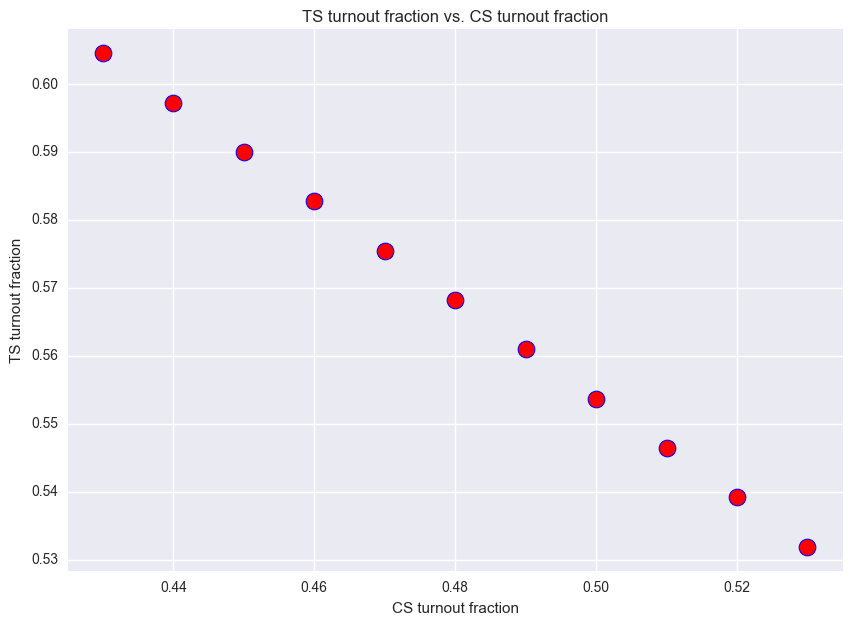

In [67]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.set_xlabel('CS turnout fraction')
ax.set_ylabel('TS turnout fraction')
ax.set_title('TS turnout fraction vs. CS turnout fraction')

ax = ax.plot(CS_turnout_fractions, 
             map(calculate_TS_factor, CS_turnout_fractions), 
             marker='o', linestyle='', markersize=12, 
             markeredgewidth=0.75,
             markerfacecolor='r', markeredgecolor='b')

Now to compute the grid of voter turnout scenarios. Note that the `NAVP_grid` doesn't depend on the urban turnout fraction since it factors in all voters.

In [68]:
NAVP_grid = {}
UNAVP_grid = {}
RNAVP_grid = {}
HPUNAVP_grid = {}
HPU_RNAVP_grid = {}
UNAVP_POP_URBAN_turnout_grid = {}
UNAVP_POP_RURAL_turnout_grid = {}
HPUNAVP_POP_URBAN_turnout_grid = {}
HPUNAVP_POP_RURAL_turnout_grid = {}

def apply_canidate_turnout_fraction (df, CS_turnout_fraction, CS = CS, electorate_fraction = electorate_fraction_by_state_2016):
    new_df = df.copy()
    TS_turnout_fraction = calculate_TS_factor(CS_turnout_fraction)
    for k, v in electorate_fraction.items():
        if k in new_df.index:
            if k in CS:
                new_df[k] = CS_turnout_fraction*v*df[k]
            else:
                new_df[k] = TS_turnout_fraction*v*df[k]
    return new_df

def apply_urban_turnout_fraction (udf, rdf, original_rdf, urban_turnout_fraction, electorate_fraction = electorate_fraction_by_state_2016):
    new_udf = udf.copy()
    new_rdf = rdf.copy()
    for k in new_udf.index:
        original_rural_pop = original_rdf[k]*electorate_fraction[k]
        rural_pop = rdf[k]
        urban_pop = udf[k]
        urban_to_rural_pop = int(urban_pop*(1.0 - urban_turnout_fraction))
        new_rural_pop = int(urban_to_rural_pop + rural_pop)
        new_urban_pop = int(urban_pop*urban_turnout_fraction)
        # make sure new rural voter turnout is less than total rural electorate
        if new_rural_pop > original_rural_pop:
            new_urban_pop = new_urban_pop + new_rural_pop - original_rural_pop
            new_rural_pop = original_rural_pop
        new_udf[k] = new_urban_pop
        new_rdf[k] = new_rural_pop
    return new_udf, new_rdf

for ctf in CS_turnout_fractions:
    NAVP_grid[ctf] = compute_weighted_average(apply_canidate_turnout_fraction(census_df.POP_ST, ctf))
    new_POP_URBAN  = apply_canidate_turnout_fraction(census_df.POP_URBAN, ctf)
    new_POP_RURAL  = apply_canidate_turnout_fraction(census_df.POP_RURAL, ctf)
    new_POP_UA     = apply_canidate_turnout_fraction(census_df.POP_UA, ctf)
    if ctf not in UNAVP_grid:
        UNAVP_grid[ctf] = {}
    if ctf not in RNAVP_grid:
        RNAVP_grid[ctf] = {}
    if ctf not in HPUNAVP_grid:
        HPUNAVP_grid[ctf] = {}
    if ctf not in HPU_RNAVP_grid:
        HPU_RNAVP_grid[ctf] = {}
    if ctf not in UNAVP_POP_URBAN_turnout_grid:
        UNAVP_POP_URBAN_turnout_grid[ctf] = {}
    if ctf not in UNAVP_POP_RURAL_turnout_grid:
        UNAVP_POP_RURAL_turnout_grid[ctf] = {}
    if ctf not in HPUNAVP_POP_URBAN_turnout_grid:
        HPUNAVP_POP_URBAN_turnout_grid[ctf] = {}
    if ctf not in HPUNAVP_POP_RURAL_turnout_grid:
        HPUNAVP_POP_RURAL_turnout_grid[ctf] = {}
    for utf in urban_turnout_fractions:
        new_new_POP_URBAN, new_new_POP_RURAL = apply_urban_turnout_fraction(new_POP_URBAN, new_POP_RURAL, census_df.POP_RURAL, utf)
        UNAVP_grid[ctf][utf] = compute_weighted_average(new_new_POP_URBAN)
        RNAVP_grid[ctf][utf] = compute_weighted_average(new_new_POP_RURAL)
        UNAVP_POP_URBAN_turnout_grid[ctf][utf] = new_new_POP_URBAN.sum()
        UNAVP_POP_RURAL_turnout_grid[ctf][utf] = new_new_POP_RURAL.sum()
        new_new_POP_UA, new_new_POP_RURAL = apply_urban_turnout_fraction(new_POP_UA, new_POP_RURAL, census_df.POP_RURAL, utf)
        HPUNAVP_grid[ctf][utf] = compute_weighted_average(new_new_POP_UA)
        HPU_RNAVP_grid[ctf][utf] = compute_weighted_average(new_new_POP_RURAL)
        HPUNAVP_POP_URBAN_turnout_grid[ctf][utf] = new_new_POP_UA.sum()
        HPUNAVP_POP_RURAL_turnout_grid[ctf][utf] = new_new_POP_RURAL.sum()

In [69]:
UNAVP_df = pd.DataFrame.from_dict(UNAVP_grid)
RNAVP_df = pd.DataFrame.from_dict(RNAVP_grid)
UNAVP_POP_URBAN_turnout_df = pd.DataFrame.from_dict(UNAVP_POP_URBAN_turnout_grid)
UNAVP_POP_RURAL_turnout_df = pd.DataFrame.from_dict(UNAVP_POP_RURAL_turnout_grid)
frac_diff_RNAVP_to_UNAVP_df = fractional_difference(RNAVP_df, UNAVP_df)
HPUNAVP_df = pd.DataFrame.from_dict(HPUNAVP_grid)
HPU_RNAVP_df = pd.DataFrame.from_dict(HPU_RNAVP_grid)
HPUNAVP_POP_URBAN_turnout_df = pd.DataFrame.from_dict(HPUNAVP_POP_URBAN_turnout_grid)
HPUNAVP_POP_RURAL_turnout_df = pd.DataFrame.from_dict(HPUNAVP_POP_RURAL_turnout_grid)
frac_diff_RNAVP_to_HPUNAVP_df = fractional_difference(HPU_RNAVP_df, HPUNAVP_df)

Here is the NAVP versus the CS turnout fraction (in plain English: this the natioanl average voting power (NAVP) at varying levels of voter turnout (applied equally to rural and urban voters) in states that Clinton won (CS)). It's clear that as turnout in CS lowers, the NAVP decreases as well. This likely reflects the composition of EC votes in the CS.

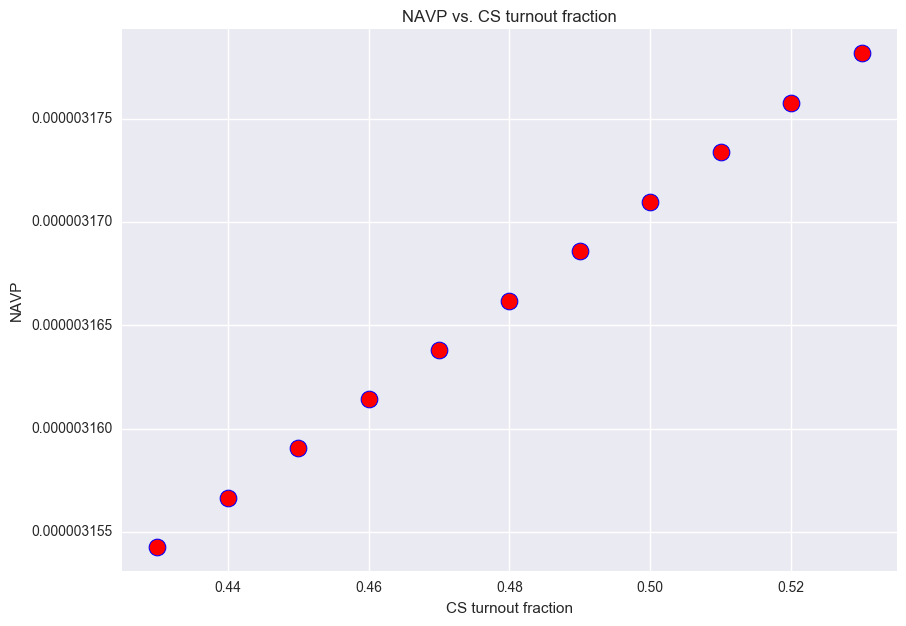

In [70]:
x = []
y = []
for k, v in NAVP_grid.items():
    x.append(k)
    y.append(v)
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax.set_xlabel('CS turnout fraction')
ax.set_ylabel('NAVP')
ax.set_title('NAVP vs. CS turnout fraction')

ax = ax.plot(x, y, 
             marker='o', linestyle='', markersize=12, 
             markeredgewidth=0.75,
             markerfacecolor='r', markeredgecolor='b')

Finally, here are what I feel are the most impactful plots. These are grids of percent differences in RNAVP w.r.t. UNAVP and HPUNAVP at varying levels of CS and urban turnout fractions. As a reminder, the urban turnout fraction is the fraction of urban voters that actually vote relative to the number of rural voters (otherwise it's assumed that the numbers of rural and urban voters is proportional to their populations). So, you can think of the urban turnout fraction as transferring votes from the urban to rural electorate. The two factors (CS and urban turnout fractions) are multiplicative.

In both grids it's clear that voting power disparity increases with lower CS turnout fractions. This suggests that the lower turnout in the CS gave more power to rural voters. However, decreasing the urban turnout fraction increases the relative number of rural votes, thus the AVP disparity actually decreases. This essentially dilutes the rural power advantage. For all scenarios the range of percent differences is about 3 to 5%. As demonstrated earlier, this can be quite noticable on a national level. 

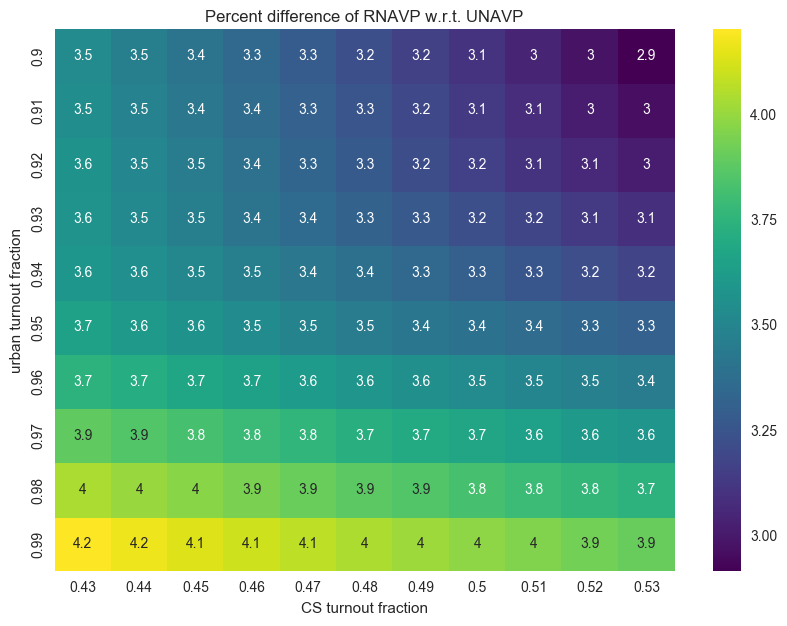

In [71]:
prev_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (10,7)
g = sns.heatmap(100*frac_diff_RNAVP_to_UNAVP_df, annot=True, cmap='viridis')
g.set_xlabel('CS turnout fraction')
g.set_ylabel('urban turnout fraction')
g.set_title('Percent difference of RNAVP w.r.t. UNAVP')
plt.rcParams['figure.figsize'] = prev_size

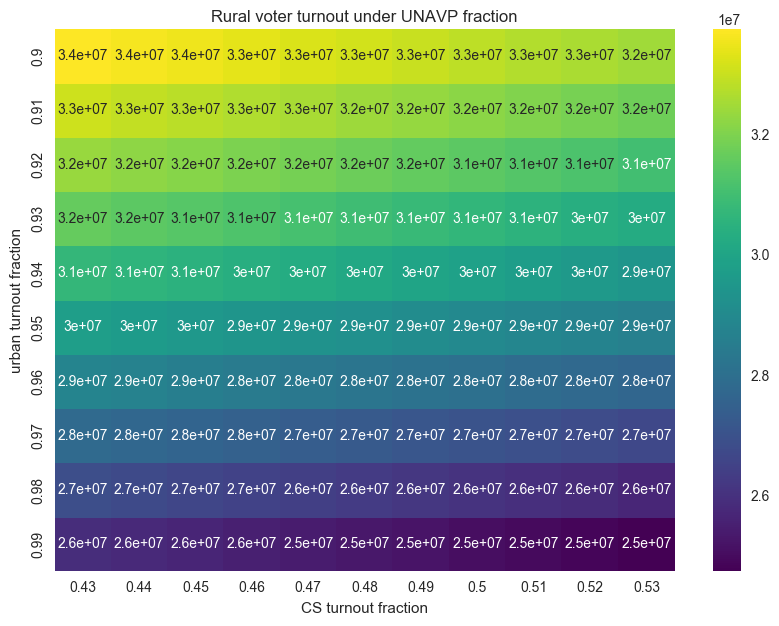

In [72]:
prev_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (10,7)
g = sns.heatmap(UNAVP_POP_RURAL_turnout_df, annot=True, cmap='viridis')
g.set_xlabel('CS turnout fraction')
g.set_ylabel('urban turnout fraction')
g.set_title('Rural voter turnout under UNAVP fraction')
plt.rcParams['figure.figsize'] = prev_size

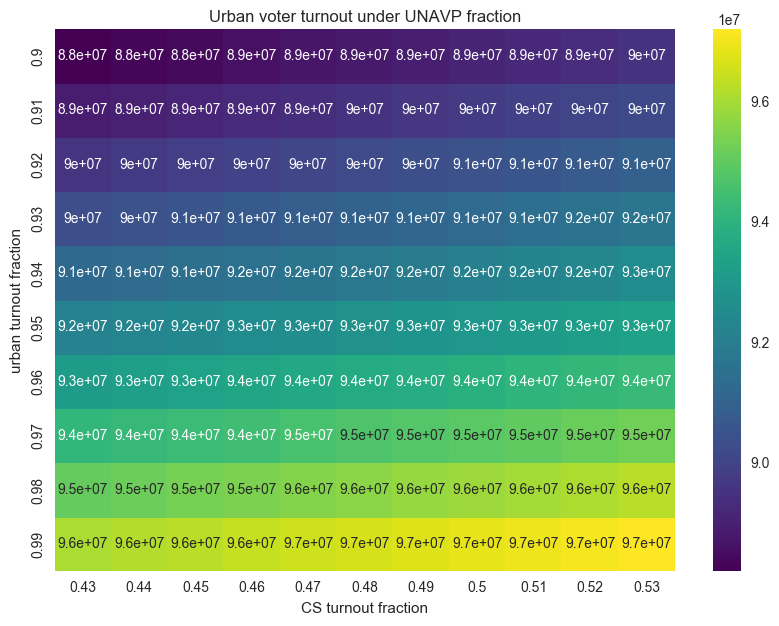

In [73]:
prev_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (10,7)
g = sns.heatmap(UNAVP_POP_URBAN_turnout_df, annot=True, cmap='viridis')
g.set_xlabel('CS turnout fraction')
g.set_ylabel('urban turnout fraction')
g.set_title('Urban voter turnout under UNAVP fraction')
plt.rcParams['figure.figsize'] = prev_size

In [77]:
#prev_size = plt.rcParams['figure.figsize']
#plt.rcParams['figure.figsize'] = (10,7)
#g = sns.heatmap(100*frac_diff_RNAVP_to_HPUNAVP_df, annot=True, cmap='viridis')
#g.set_xlabel('CS turnout fraction')
#g.set_ylabel('urban turnout fraction')
#g.set_title('Percent difference of RNAVP w.r.t. HPUNAVP')
#plt.rcParams['figure.figsize'] = prev_size

So, to actual get voter numbers from this I can see that for a CS turnout fraction of 50% (lower than that in TS) and an urban turnout fraction of 90% the rural voter turnout is roughly 33 million voters (nationally). At an AVP disparity of 3.1% this would equate to about 1.02 million more votes that the urban population would have to come up with to be on parity with the power of the rural vote.

In [82]:
utf = 0.9
ctf = 0.5
print 'National turnout:                 {}'.format(UNAVP_POP_RURAL_turnout_df[ctf][utf]+UNAVP_POP_URBAN_turnout_df[ctf][utf])
print 'National turnout percentage:      {:.1f}%'.format(100*national_turnout_frac)
print 'National rural turnout:           {}'.format(UNAVP_POP_RURAL_turnout_df[ctf][utf])
print 'National urban turnout:           {}'.format(UNAVP_POP_URBAN_turnout_df[ctf][utf])
print 'National rural AVP advantage:     {:.2}%'.format(100*frac_diff_RNAVP_to_UNAVP_df[ctf][utf])
print 'Effecitive number of rural votes: {}'.format(int(UNAVP_POP_RURAL_turnout_df[ctf][utf]*(1+frac_diff_RNAVP_to_UNAVP_df[ctf][utf])))
print 'Net difference of rural votes:    {}'.format(int(UNAVP_POP_RURAL_turnout_df[ctf][utf]*(frac_diff_RNAVP_to_UNAVP_df[ctf][utf])))

National turnout:                 121999892
National turnout percentage:      53.1%
National rural turnout:           32885981
National urban turnout:           89113911
National rural AVP advantage:     3.1%
Effecitive number of rural votes: 33908448
Net difference of rural votes:    1022467


## Summary, Thoughts, and Critiques

I've quantitatively shown that under ideal circumstances (100% voter turnout) and more realistic scenarios that the Electoral College gives more average voting power to rural voters versus urban voters. These more realistic scenarios account for national voter turnout and voter turnout disparities regarding which candidate won certain states and urban-rural relative voting rates. At a national level, this ranges from 3 to 5% percent in favor of rural voters. This can effectively lead to about a million additional votes that urban voters must counteract to stay at parity. 

One of the primary reasons the EC was created was to encourage participation in newly adopted states. The three vote minimum increases the influence of sparsely populated regions and ensured that the US (a frontier nation at the time) respected the new states. We are no longer a frontier nation as all states are well established with robust infrastructures and healthy citizenries. Each state also has two senators to equally influence legislation. However, the presidential election is conducted as a popular election and as such, I argue, it shouldn't be constrained by a system that artificially favors sparse regions. As a person living in a region classified as "urban" by the US census, I'm not content to have my vote count less than those that happen to live in "rural" regions. I've noticed that it just so happens that the most fervent defenders of this institution are the ones advantaged by it (those in rural areas or with politics that align with rural politics). This can come off as more than a little self-serving.

Finally, this analysis can be improved in a number of ways. The most obvious is to obtain the actual estimates of rural and urban voter turnout on a per-states level. Additionally, estimates of the political leanings of the rural and urban populations per state would greatly enrich this analysis. Short of these estimates, obtaining rural and urban total population data for 2016 would help with accuracy. However, this would likely not change the outcome by much. All of the numbers used here have some inherit margin of error that I ignore for the sake of brevity.